In [88]:
import warnings
warnings.filterwarnings('ignore')

In [89]:
# !pip install gensim

In [90]:
# !pip install razdel

In [91]:
# !pip install pymorphy2

In [92]:
# !pip install nltk

In [93]:
import pandas as pd

Наши новости

In [94]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [95]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [96]:
from gensim.corpora.dictionary import Dictionary
import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize 
import pymorphy2

In [97]:
import nltk

In [98]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [99]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))
morph = pymorphy2.MorphAnalyzer()

151


In [100]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [101]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [102]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 47.8 s


In [103]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 58s


In [104]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [105]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)

In [106]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [107]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.1827173),
 (7, 0.2247088),
 (9, 0.10987899),
 (14, 0.40476066),
 (20, 0.060103443)]

In [108]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [109]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [110]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.408255,0.013842,0.0,0.0,0.034059,0.0
1,4896,0.000000,0.0,0.000000,0.000000,0.000000,0.588886,0.000000,0.000000,0.0,...,0.209793,0.0,0.0,0.0,0.000000,0.114852,0.0,0.0,0.000000,0.0
2,4897,0.000000,0.0,0.000000,0.000000,0.182717,0.000000,0.000000,0.224740,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.060108,0.0,0.0,0.000000,0.0
3,4898,0.000000,0.0,0.062087,0.399715,0.000000,0.000000,0.027479,0.453968,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.047278,0.0,0.0,0.000000,0.0
4,4899,0.831689,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


###  векторные представления пользователей

In [111]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [112]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [113]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [114]:
user_articles_list = users['articles'].iloc[33]
get_user_embedding(user_articles_list)

array([0.05461481, 0.00275006, 0.03198705, 0.07471297, 0.        ,
       0.02888065, 0.00204398, 0.06892346, 0.01056609, 0.        ,
       0.00493086, 0.19802876, 0.        , 0.0319107 , 0.09514903,
       0.06345931, 0.        , 0.00847794, 0.01727938, 0.25629257,
       0.        , 0.        , 0.        , 0.        , 0.03994233])

In [115]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.011219,0.017198,0.000000,0.073028,0.003721,0.023366,0.034142,0.065577,0.000000,...,0.069339,0.0,0.003281,0.019506,0.244679,0.011008,0.000000,0.007844,0.011427,0.099518
1,u108690,0.010094,0.018575,0.005057,0.127506,0.006532,0.012559,0.021078,0.159093,0.001829,...,0.087273,0.0,0.000000,0.002625,0.219032,0.000000,0.005117,0.013432,0.000000,0.002346
2,u108339,0.065567,0.011415,0.001743,0.031301,0.001796,0.060899,0.084782,0.037687,0.004547,...,0.143275,0.0,0.000000,0.004830,0.296787,0.000000,0.000000,0.003497,0.004506,0.020608


### можно попробовать обучить модель

In [181]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [182]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.048878,0.103189,0.000000,0.177491,0.022325,0.091687,0.168753,0.224055,0.000000,...,0.0,0.019684,0.092315,0.313861,0.066045,0.000000,0.047064,0.068560,0.401808,0
1,u108690,0.060561,0.086776,0.030340,0.241342,0.025390,0.061366,0.089178,0.387479,0.010977,...,0.0,0.000000,0.015750,0.422195,0.000000,0.030701,0.080594,0.000000,0.014076,1
2,u108339,0.130203,0.040962,0.010456,0.089616,0.010773,0.287999,0.222289,0.059014,0.027282,...,0.0,0.000000,0.028977,0.432776,0.000000,0.000000,0.020981,0.014376,0.110398,1


In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [185]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08377024, 0.01448251, 0.51988331, 0.0754275 , 0.00914004,
       0.00662611, 0.02517773, 0.03591574, 0.0587053 , 0.09271615])

In [187]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [188]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.383342, F-Score=0.754, Precision=0.765, Recall=0.743


In [189]:
roc_auc = roc_auc_score(y_test, preds)
print(f'roc_auc = {roc_auc:.3f}')

roc_auc = 0.970


In [190]:
with open('results.txt', 'w') as f:
    f.write(f'User embedding with np.mean:\n\n'
            f'Best Threshold = {thresholds[ix]:.3f}\n'
            f'F-Score = {fscore[ix]:.3f}\n'
            f'Precision = {precision[ix]:.3f}\n'
            f'Recall = {recall[ix]:.3f}\n'
            f'roc_auc = {roc_auc:.3f}\n\n')

In [191]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1699   56]
 [  64  181]]


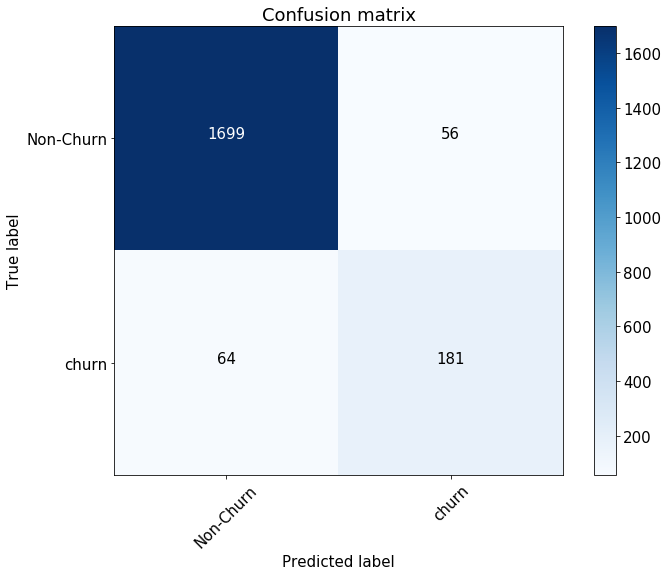

In [192]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_mean.png")
plt.show()

In [193]:
data = [' ', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]
columns = ['type of emb', 'Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc']      
result_df = pd.DataFrame({'type of emb' : ['mean'],
                          'Best Threshold' : [thresholds[ix]],
                          'F-Score' : [fscore[ix]],
                          'Precision' : [precision[ix]],
                          'Recall' : [recall[ix]],
                          'roc_auc' : [roc_auc]}, columns=columns)
result_df

,type of emb,Best Threshold,F-Score,Precision,Recall,roc_auc
0,mean,0.383342,0.753623,0.764706,0.742857,0.969612


Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [194]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [195]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.00000,0.000000,0.0,0.081062,0.0,0.000000,0.000000,0.039202,0.0,...,0.025430,0.0,0.0,0.0,0.298982,0.0,0.0,0.0,0.0,0.0
1,u108690,0.00000,0.005783,0.0,0.146459,0.0,0.000000,0.000000,0.139108,0.0,...,0.067624,0.0,0.0,0.0,0.190055,0.0,0.0,0.0,0.0,0.0
2,u108339,0.06802,0.005043,0.0,0.021783,0.0,0.016972,0.055194,0.050090,0.0,...,0.102932,0.0,0.0,0.0,0.359890,0.0,0.0,0.0,0.0,0.0


In [196]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.00000,0.000000,0.0,0.081062,0.0,0.000000,0.000000,0.039202,0.0,...,0.0,0.0,0.0,0.298982,0.0,0.0,0.0,0.0,0.0,0
1,u108690,0.00000,0.005783,0.0,0.146459,0.0,0.000000,0.000000,0.139108,0.0,...,0.0,0.0,0.0,0.190055,0.0,0.0,0.0,0.0,0.0,1
2,u108339,0.06802,0.005043,0.0,0.021783,0.0,0.016972,0.055194,0.050090,0.0,...,0.0,0.0,0.0,0.359890,0.0,0.0,0.0,0.0,0.0,1


In [197]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [198]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [199]:
preds = logreg.predict_proba(X_test)[:, 1]

In [200]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.247761, F-Score=0.763, Precision=0.690, Recall=0.853


In [201]:
roc_auc = roc_auc_score(y_test, preds)
print(f'roc_auc = {roc_auc:.3f}')

roc_auc = 0.967


In [202]:
with open('results.txt', 'a') as f:
    f.write(f'User embedding with np.median:\n\n'
            f'Best Threshold = {thresholds[ix]:.3f}\n'
            f'F-Score = {fscore[ix]:.3f}\n'
            f'Precision = {precision[ix]:.3f}\n'
            f'Recall = {recall[ix]:.3f}\n'
            f'roc_auc = {roc_auc:.3f}\n\n')

Confusion matrix, without normalization
[[1661   94]
 [  37  208]]


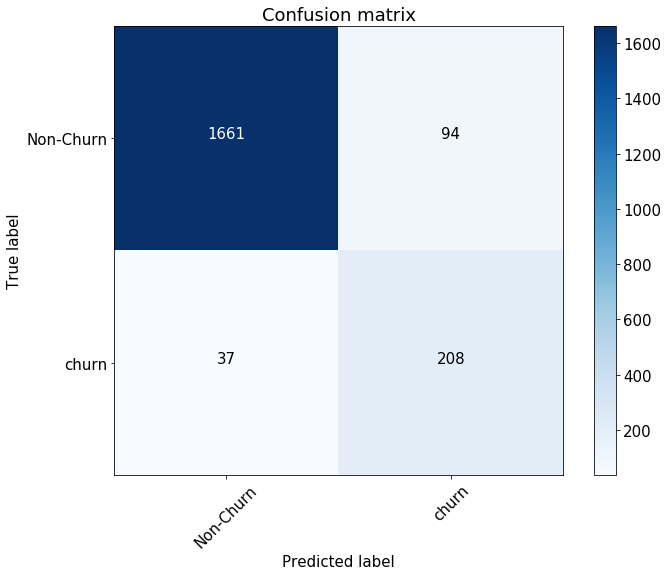

In [203]:
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_median.png")
plt.show()

In [204]:
result_df = result_df.append({'type of emb' : 'median',
                          'Best Threshold' : thresholds[ix],
                          'F-Score' : fscore[ix],
                          'Precision' : precision[ix],
                          'Recall' : recall[ix],
                          'roc_auc' : roc_auc}, ignore_index=True)
result_df

,type of emb,Best Threshold,F-Score,Precision,Recall,roc_auc
0,mean,0.383342,0.753623,0.764706,0.742857,0.969612
1,median,0.247761,0.762774,0.689769,0.853061,0.966547


Повторить п.2, но используя уже не медиану, а max

In [205]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [206]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [207]:
X = pd.merge(user_embeddings, target, 'left')

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [209]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [210]:
preds = logreg.predict_proba(X_test)[:, 1]

In [211]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.383342, F-Score=0.754, Precision=0.765, Recall=0.743


In [212]:
roc_auc = roc_auc_score(y_test, preds)
print(f'roc_auc = {roc_auc:.3f}')

roc_auc = 0.970


In [213]:
with open('results.txt', 'a') as f:
    f.write(f'User embedding with np.max:\n\n'
            f'Best Threshold = {thresholds[ix]:.3f}\n'
            f'F-Score = {fscore[ix]:.3f}\n'
            f'Precision = {precision[ix]:.3f}\n'
            f'Recall = {recall[ix]:.3f}\n'
            f'roc_auc = {roc_auc:.3f}\n\n')

Confusion matrix, without normalization
[[1699   56]
 [  64  181]]


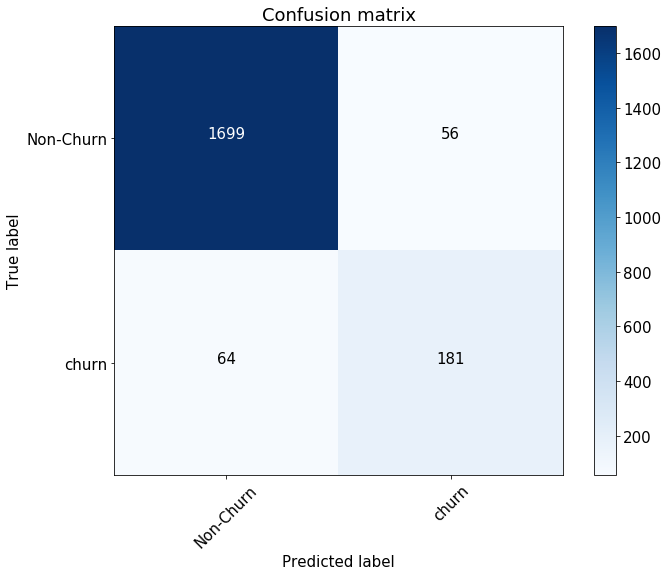

In [214]:
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_max.png")
plt.show()

In [215]:
result_df = result_df.append({'type of emb' : 'max',
                          'Best Threshold' : thresholds[ix],
                          'F-Score' : fscore[ix],
                          'Precision' : precision[ix],
                          'Recall' : recall[ix],
                          'roc_auc' : roc_auc}, ignore_index=True)

,type of emb,Best Threshold,F-Score,Precision,Recall,roc_auc
0,mean,0.383342,0.753623,0.764706,0.742857,0.969612
1,median,0.247761,0.762774,0.689769,0.853061,0.966547
2,max,0.383342,0.753623,0.764706,0.742857,0.969612


Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [217]:
result_df

,type of emb,Best Threshold,F-Score,Precision,Recall,roc_auc
0,mean,0.383342,0.753623,0.764706,0.742857,0.969612
1,median,0.247761,0.762774,0.689769,0.853061,0.966547
2,max,0.383342,0.753623,0.764706,0.742857,0.969612


In [218]:
result_df.to_csv('Result.csv', index=False)

In [216]:
with open('results.txt', 'r') as f:
    print(f.read())

User embedding with np.mean:

Best Threshold = 0.383
F-Score = 0.754
Precision = 0.765
Recall = 0.743
roc_auc = 0.970

User embedding with np.median:

Best Threshold = 0.248
F-Score = 0.763
Precision = 0.690
Recall = 0.853
roc_auc = 0.967

User embedding with np.max:

Best Threshold = 0.383
F-Score = 0.754
Precision = 0.765
Recall = 0.743
roc_auc = 0.970




попробуем idf

In [219]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [220]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [221]:
users['articles'] = users['articles'].apply(lambda x: " ".join([i.strip() for i in x.replace("[","").replace("]","").split(",")]), 
                                            1)
users['articles'].iloc[0]

'293672 293328 293001 293622 293126 1852'

In [222]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [223]:
pd.DataFrame({'article_id': tfidf.get_feature_names(),
              'idf': tfidf.idf_})

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [224]:
users.head()

,uid,articles
0,u105138,293672 293328 293001 293622 293126 1852
1,u108690,3405 1739 2972 1158 1599 322665
2,u108339,1845 2009 2356 1424 2939 323389
3,u101138,5933 6186 5055 6977 5206 488389
4,u108248,707 1144 2532 2928 3133 324592
